In [1]:
# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline

from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
from keras.applications import ResNet50

Using TensorFlow backend.


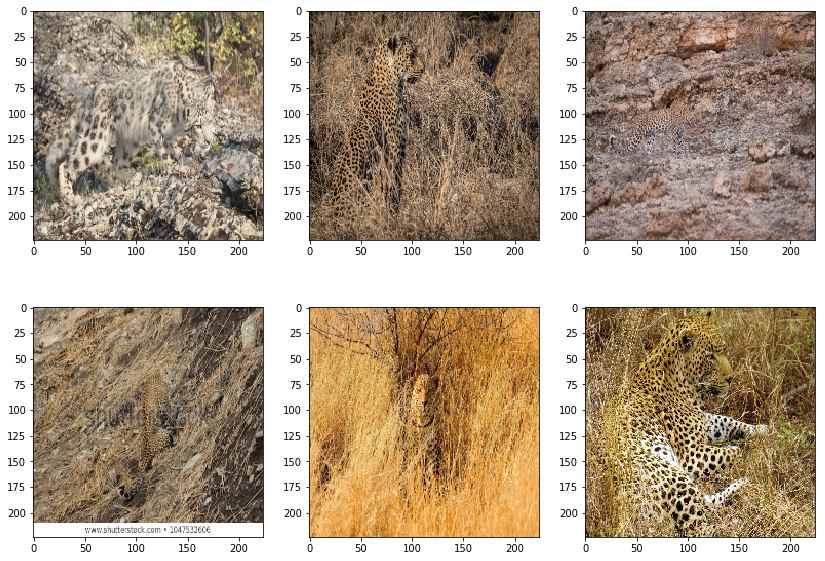

In [2]:
plt.rcParams['figure.figsize'] = (14, 10)

img1 = utils.load_img('D:/Pictures/Saved Pictures/leo_1.jpg', target_size=(224, 224))
img2 = utils.load_img('D:/Pictures/Saved Pictures/leo_2.jpg', target_size=(224, 224))
img3 = utils.load_img('D:/Pictures/Saved Pictures/leo_3.jpg', target_size=(224, 224))
img4 = utils.load_img('D:/Pictures/Saved Pictures/leo_4.jpg', target_size=(224, 224))
img5 = utils.load_img('D:/Pictures/Saved Pictures/leo_5.jpg', target_size=(224, 224))
img6 = utils.load_img('D:/Pictures/Saved Pictures/leo_6.jpg', target_size=(224, 224))

f, ax = plt.subplots(nrows=2, ncols=3)
ax[0, 0].imshow(img1)
ax[0, 1].imshow(img2)
ax[0, 2].imshow(img3)
ax[1, 0].imshow(img4)
ax[1, 1].imshow(img5)
ax[1, 2].imshow(img6)

In [3]:
cougars = [img1,img2,img3,img4,img5,img6]

In [4]:
# import compiled ResNet50 network with ImageNet weights
model = ResNet50(weights='imagenet', include_top=True)

# View network layout
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
# Utility to search for layer index by name. 

layer_idx = utils.find_layer_idx(model, 'fc1000')  # can also replace with '-1', corresponding to the last layer

# Swap last layer's softmax activation with linear
model.layers[layer_idx].activation = activations.linear

# Apply modification
model = utils.apply_modifications(model)

In [6]:
gradients=[]


for index, img in enumerate(cougars):    
    
    # Visualize which pixels affect output label most
    # ImageNet filter index for leopard is '288'
    
    grads = visualize_saliency(model, layer_idx, filter_indices=288, seed_input=cougars[index])
    
    # Append gradient arrays to list variable for visualization
    
    gradients.append(grads)

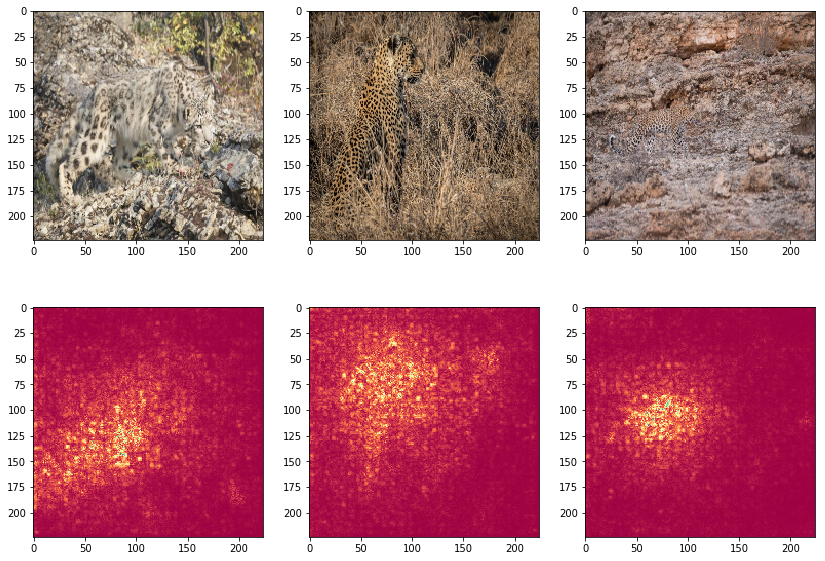

In [7]:
# visualize grads as heatmap for first three images

f, ax = plt.subplots(2, 3)

# First row with original images
ax[0,0].imshow(cougars[0])
ax[0,1].imshow(cougars[1])
ax[0,2].imshow(cougars[2])

# Second row with salency maps
ax[1,0].imshow(gradients[0], cmap='Spectral')
ax[1,1].imshow(gradients[1], cmap='Spectral')
ax[1,2].imshow(gradients[2], cmap='Spectral')

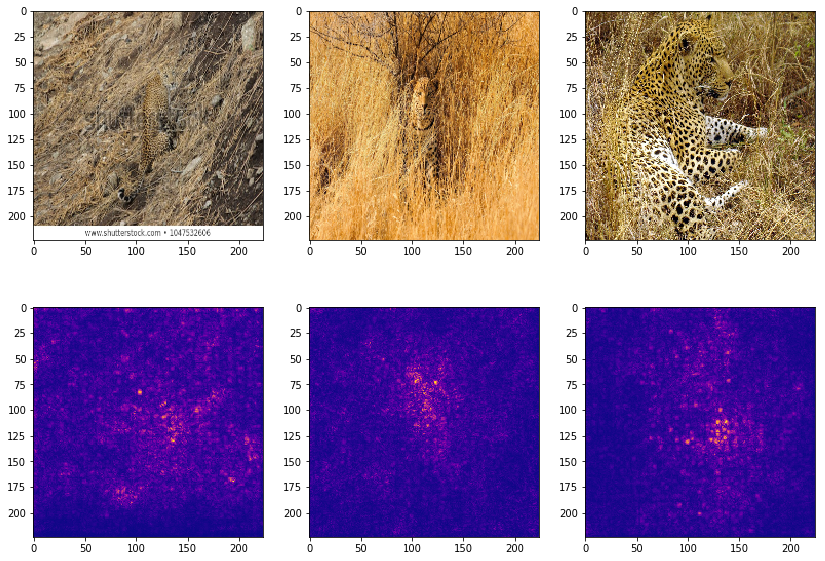

In [8]:
# Visualize grads as heatmap for last three images

f, ax = plt.subplots(2, 3)

# First row with original images
ax[0,0].imshow(cougars[3])
ax[0,1].imshow(cougars[4])
ax[0,2].imshow(cougars[5])

# Second row with salency maps
ax[1,0].imshow(gradients[3], cmap='plasma')
ax[1,1].imshow(gradients[4], cmap='plasma')
ax[1,2].imshow(gradients[5], cmap='plasma')

<Figure size 1008x720 with 0 Axes>

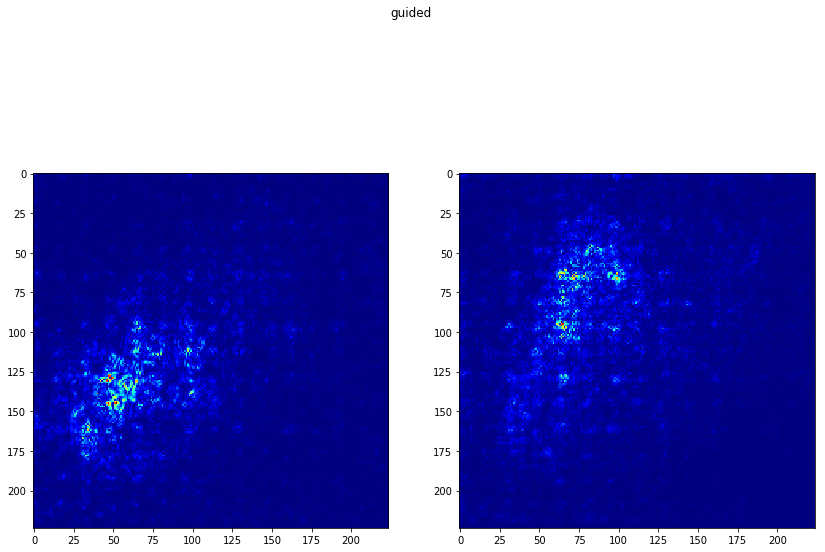

<Figure size 1008x720 with 0 Axes>

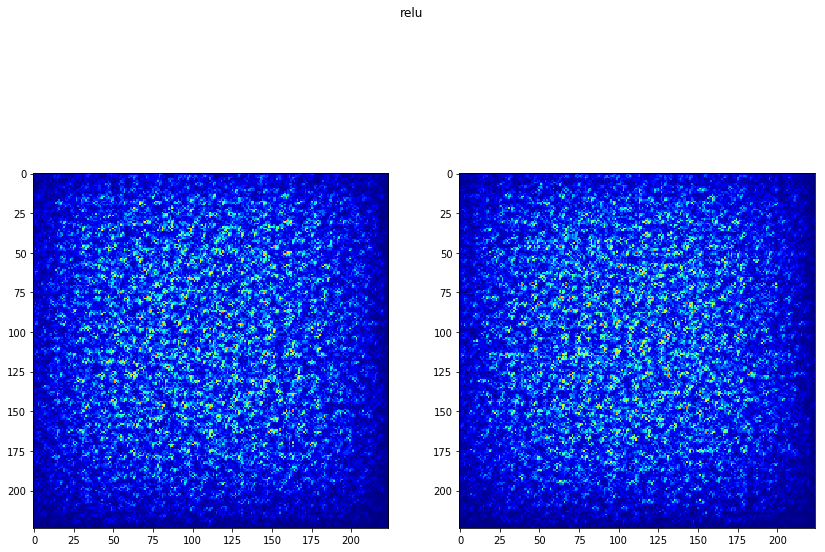

In [9]:
# Example with backpropagation modifier

for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    
    for index, img in enumerate([img1, img2]):    
        
        # Get salency map arrays
        grads = visualize_saliency(model, layer_idx, filter_indices=288, 
                                   seed_input=img, backprop_modifier=modifier)
        
        # Overlay the heatmap onto original image.    
        ax[index].imshow(grads, cmap='jet')

<Figure size 1008x720 with 0 Axes>

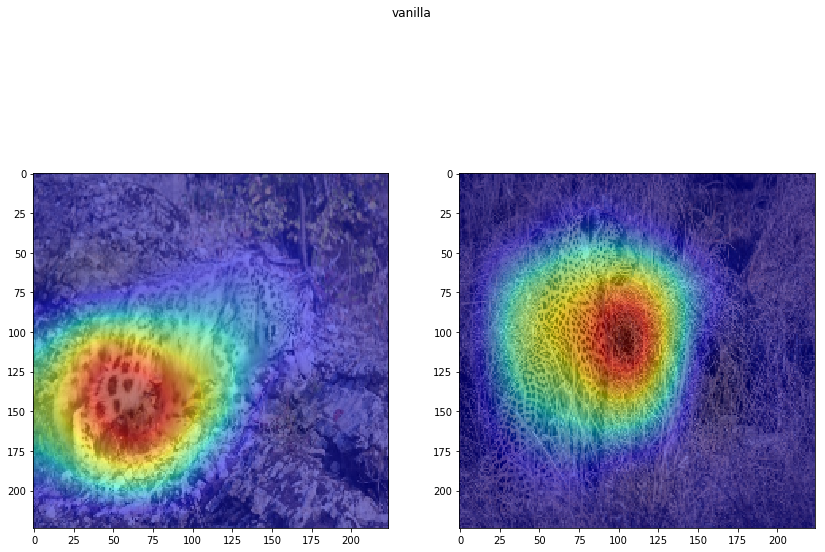

<Figure size 1008x720 with 0 Axes>

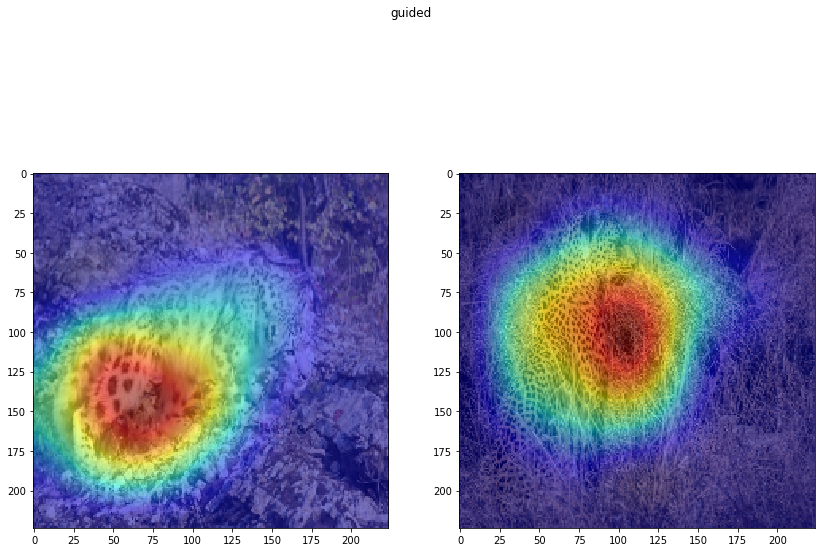

<Figure size 1008x720 with 0 Axes>

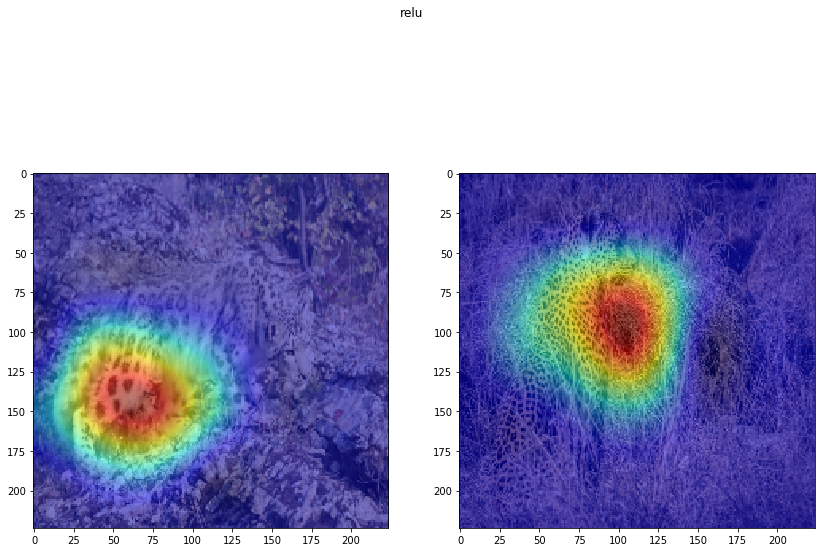

In [18]:
# Visualizing class activation map with keras-vis

import matplotlib.cm as cm
from vis.visualization import visualize_cam

penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')

# for each backprob modifier
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    
    # Make two subplots
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    
    # For each image
    for index, img in enumerate([img1, img2]):
        
        # Collect class activation arrays
        grads = visualize_cam(model, layer_idx, filter_indices=288, 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        
        # Overlay onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[index].imshow(overlay(jet_heatmap, img))

In [11]:
from keras.preprocessing.image import img_to_array

# convert the image pixels to a numpy array
img_1 = img_to_array(img1)

In [12]:
# Reshape as batch of 1 image, with dimensions 224 x 224 x 3 

img_1 = img_1.reshape((1, img_1.shape[0], img_1.shape[1], img_1.shape[2]))

In [13]:
# Check shape

img_1.shape

(1, 224, 224, 3)

In [14]:
# Make prediction with pre-trained ResNet50 on an image

yhat = model.predict(img_1)

In [15]:
# Import label decoder for the ResNet50 model
from keras.applications.resnet50 import decode_predictions

# Decode predictions using class labels
predictions = decode_predictions(yhat, top=1000)

# Retrieve the most likely result, e.g. highest probability
label = predictions[0][0]

# Retrieve n most likely results, in decreasing probability
labels = predictions[0][:]

# Print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

snow_leopard (1080.04%)


In [16]:
# Print most likely predictiom
label[:]

('n02128757', 'snow_leopard', 10.800396)

In [17]:
# Print top 5 predictions
labels[:5]

[('n02128757', 'snow_leopard', 10.800396),
 ('n02130308', 'cheetah', 9.888457),
 ('n02100735', 'English_setter', 8.046139),
 ('n02128385', 'leopard', 7.3484097),
 ('n02110341', 'dalmatian', 6.5762362)]